In [ ]:
import pandas as pd 
import numpy as np

from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
days_to_predict = int(input('How many days from today do you want to predict? '))
print(days_to_predict)
while days_to_predict==0 or days_to_predict >  3:
  print('Please enter a number that is more than 0 and less than or equals to 3.')
  days_to_predict = int(input('How many days from today do you want to predict? '))

How many days from today do you want to predict? 3
3


In [ ]:
import datetime
today =  datetime.date.today()
year_today = today.year
month_today = today.month
day_today = today.day

future = datetime.date.today() + datetime.timedelta(days=days_to_predict)
year_future = future.year
month_future = future.month
day_future = future.day

future_df = (pd.DataFrame(columns=['NULL'],
                  index=pd.date_range(today, future,
                                      freq='30T'))
       .between_time('09:30','15:30')
       .index.strftime('%Y-%m-%d %H:%M:%S')
       .tolist()
)

future_df = pd.DataFrame(future_df, columns=['created_at'])
future_df['created_at'] = future_df["created_at"].apply(pd.to_datetime)
future_df = future_df[future_df['created_at'].dt.weekday < 5]
future_df = future_df.set_index('created_at')
future_df['Close'] = np.nan
future_df['Comp'] = np.nan
future_df

,Close,Comp
created_at,,
2021-03-29 09:30:00,NaN,NaN
2021-03-29 10:00:00,NaN,NaN
2021-03-29 10:30:00,NaN,NaN
2021-03-29 11:00:00,NaN,NaN
2021-03-29 11:30:00,NaN,NaN
2021-03-29 12:00:00,NaN,NaN
2021-03-29 12:30:00,NaN,NaN
2021-03-29 13:00:00,NaN,NaN
2021-03-29 13:30:00,NaN,NaN


In [ ]:
predict_rows = len(future_df)
print(predict_rows)

26


In [ ]:
final = pd.read_csv('final.csv') 
final = final.set_index('Datetime')
final.head()

,Close,Comp
Datetime,,
2020-12-30 09:30:00,37.099998,0.668767
2020-12-30 10:00:00,37.009998,0.143571
2020-12-30 10:30:00,37.090000,0.317000
2020-12-30 11:00:00,37.079899,0.047514
2020-12-30 11:30:00,37.044998,0.317800


In [ ]:
#Scaling for dataframes with 2 columns
# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
sc = MinMaxScaler()
 
DataScaler = sc.fit(final)
X = DataScaler.transform(final)

In [ ]:
#Scaling for dataframes with 1 column
# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
df_price = final.drop(columns='Comp')

sc_y = MinMaxScaler()
 
DataScaler_y = sc_y.fit(df_price)
Y = DataScaler_y.transform(df_price)

In [ ]:
# split into samples
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps= 26  # Price Prediction for n days is based on last how many rows of data, 26 = 2 days
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

In [ ]:
X_data=np.array(X_samples)
X_data.shape

(760, 26, 2)

In [ ]:
################################################
# Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], -1)
print('\n#### Input Data shape ####')
print(X_data.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], -1)
print('\n#### Output Data shape ####')
print(y_data.shape)


#### Input Data shape ####
(760, 26, 2)

#### Output Data shape ####
(760, 2)


In [ ]:
# Choosing the number of testing data records
TestingRecords= round(0.2 * y_data.shape[0]) #take 20% of the data for testing

# Splitting the data into train and test
#https://datascience.stackexchange.com/questions/30762/how-to-predict-the-future-values-of-time-horizon-with-keras
X_train=X_data[:-TestingRecords+predict_rows]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords+predict_rows]
y_test=y_data[-TestingRecords:]
 
############################################
 
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(634, 26, 2)
(634, 2)

#### Testing Data shape ####
(152, 26, 2)
(152, 2)


In [ ]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 26
Number of Features: 2


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# Initialising the RNN
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'tanh', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'tanh', return_sequences=False )) 
 
# Adding the Third output layer
regressor.add(Dense(units = 1))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
##################################################
 
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 3, epochs = 50)
 
EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

Epoch 1/50
212/212 [==============================] - 7s 17ms/step - loss: 0.0418
Epoch 2/50
212/212 [==============================] - 4s 17ms/step - loss: 0.0309
Epoch 3/50
212/212 [==============================] - 3s 16ms/step - loss: 0.0285
Epoch 4/50
212/212 [==============================] - 3s 16ms/step - loss: 0.0289
Epoch 5/50
212/212 [==============================] - 3s 16ms/step - loss: 0.0262
Epoch 6/50
212/212 [==============================] - 3s 16ms/step - loss: 0.0282
Epoch 7/50
212/212 [==============================] - 3s 14ms/step - loss: 0.0266
Epoch 8/50
212/212 [==============================] - 3s 15ms/step - loss: 0.0269
Epoch 9/50
212/212 [==============================] - 3s 15ms/step - loss: 0.0273
Epoch 10/50
212/212 [==============================] - 3s 15ms/step - loss: 0.0266
Epoch 11/50
212/212 [==============================] - 3s 15ms/step - loss: 0.0277
Epoch 12/50
212/212 [==============================] - 3s 15ms/step - loss: 0.0260
Epoch 13/50
2

In [ ]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler_y.inverse_transform(predicted_Price)

# Getting the original price values for testing data
orig=y_test
orig=DataScaler_y.inverse_transform(y_test)

# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())

Accuracy: 99.16988036213574


In [ ]:
# Generating predictions on full data
TrainPredictions=DataScaler_y.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler_y.inverse_transform(regressor.predict(X_test))

FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=final[TimeSteps:]

FullDataOrig = FullDataOrig.append(future_df)
FullDataOrig['Predicted_Close'] = FullDataPredictions
FullDataOrig

,Close,Comp,Predicted_Close
2021-01-01 09:30:00,36.790001,0.265300,36.358036
2021-01-01 10:00:00,36.790001,0.245100,36.331097
2021-01-01 10:30:00,36.790001,0.257640,36.320087
2021-01-01 11:00:00,36.790001,0.113250,36.316307
2021-01-01 11:30:00,36.790001,0.501367,36.295177
...,...,...,...
2021-03-30 13:30:00,NaN,NaN,35.800816
2021-03-30 14:00:00,NaN,NaN,35.861416
2021-03-30 14:30:00,NaN,NaN,35.893414
2021-03-30 15:00:00,NaN,NaN,35.933006


In [ ]:
FullDataOrig.index=FullDataOrig.index.astype(str)
FullDataOrig

,Close,Comp,Predicted_Close
2021-01-01 09:30:00,36.790001,0.265300,36.358036
2021-01-01 10:00:00,36.790001,0.245100,36.331097
2021-01-01 10:30:00,36.790001,0.257640,36.320087
2021-01-01 11:00:00,36.790001,0.113250,36.316307
2021-01-01 11:30:00,36.790001,0.501367,36.295177
...,...,...,...
2021-03-30 13:30:00,NaN,NaN,35.800816
2021-03-30 14:00:00,NaN,NaN,35.861416
2021-03-30 14:30:00,NaN,NaN,35.893414
2021-03-30 15:00:00,NaN,NaN,35.933006


### Check RMSE

In [ ]:
from statsmodels.tools.eval_measures import rmse

df1 = FullDataOrig.dropna()
error = rmse(df1['Predicted_Close'],df1['Close'])
error

0.5665895860934317

In [ ]:
from statsmodels.tools.eval_measures import rmse

error = rmse(df1['Predicted_Close'],df1['Close'])
print('Mean squared error =',round(error,2))

Mean squared error = 0.57


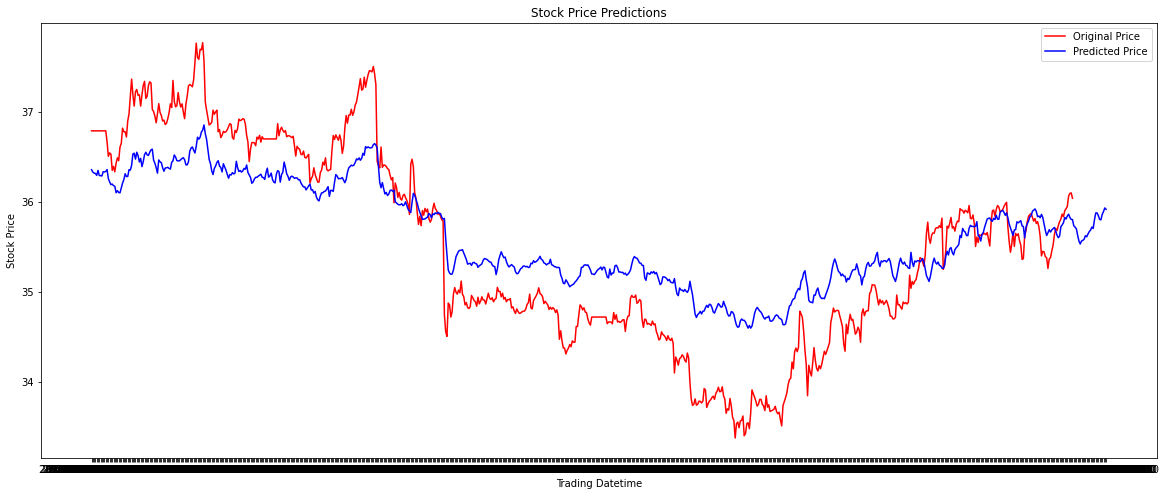

In [ ]:
# plotting the full data
plt.plot(FullDataOrig['Close'] , color = 'red', label = 'Original Price')
plt.plot(FullDataOrig['Predicted_Close'] , color = 'blue', label = 'Predicted Price')


plt.title('Stock Price Predictions')
plt.xlabel('Trading Datetime')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

## Normalised predictions

In [ ]:
FullDataOrig.index.names = ['Datetime']
FullDataOrig 

,Close,Comp,Predicted_Close
Datetime,,,
2021-01-01 09:30:00,36.790001,0.265300,36.358036
2021-01-01 10:00:00,36.790001,0.245100,36.331097
2021-01-01 10:30:00,36.790001,0.257640,36.320087
2021-01-01 11:00:00,36.790001,0.113250,36.316307
2021-01-01 11:30:00,36.790001,0.501367,36.295177
...,...,...,...
2021-03-30 13:30:00,NaN,NaN,35.800816
2021-03-30 14:00:00,NaN,NaN,35.861416
2021-03-30 14:30:00,NaN,NaN,35.893414


In [ ]:
FullDataOrig.to_csv('PFE_LSTM_Dashboard.csv') 

In [ ]:
from sklearn import preprocessing

final_pred_scaling = FullDataOrig['Predicted_Close'].reset_index()
final_pred_scaling = final_pred_scaling['Predicted_Close'] 
final_pred_scaling = preprocessing.scale(np.asarray(final_pred_scaling))
final_pred_scaling

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


array([ 1.29732835e+00,  1.24939036e+00,  1.22979987e+00,  1.22307277e+00,
        1.18547320e+00,  1.28366375e+00,  1.18114233e+00,  1.18058574e+00,
        1.17255533e+00,  1.25722396e+00,  1.25223470e+00,  1.26302099e+00,
        1.29971099e+00,  1.12024593e+00,  1.05541229e+00,  1.00225425e+00,
        1.01253152e+00,  9.80715573e-01,  9.71347928e-01,  8.41870785e-01,
        8.81724000e-01,  8.46588552e-01,  8.39080870e-01,  9.40102100e-01,
        1.03250909e+00,  1.10046518e+00,  1.21747255e+00,  1.16103590e+00,
        1.16458607e+00,  1.29799354e+00,  1.28800142e+00,  1.38414872e+00,
        1.60759425e+00,  1.62341738e+00,  1.50627434e+00,  1.64261425e+00,
        1.57474637e+00,  1.45007527e+00,  1.52138472e+00,  1.35817051e+00,
        1.45759654e+00,  1.59477818e+00,  1.64205766e+00,  1.59139097e+00,
        1.57958627e+00,  1.64158249e+00,  1.68946612e+00,  1.70395195e+00,
        1.48820424e+00,  1.42510164e+00,  1.33999860e+00,  1.22922957e+00,
        1.48995566e+00,  

In [ ]:
final_pred_scaling = final_pred_scaling.reshape(-1,1)

In [ ]:
df_normalised_pred = pd.DataFrame(final_pred_scaling, columns =['Pred_Norm_Close'])
df_normalised_pred.index = FullDataOrig.index
df_normalised_pred.index.names = ['Datetime']
df_normalised_pred

,Pred_Norm_Close
Datetime,
2021-01-01 09:30:00,1.297328
2021-01-01 10:00:00,1.249390
2021-01-01 10:30:00,1.229800
2021-01-01 11:00:00,1.223073
2021-01-01 11:30:00,1.185473
...,...
2021-03-30 13:30:00,0.305770
2021-03-30 14:00:00,0.413607
2021-03-30 14:30:00,0.470546


In [ ]:
df_normalised_pred = df_normalised_pred[df_normalised_pred.index >= '2021-03-05 11:30:00']

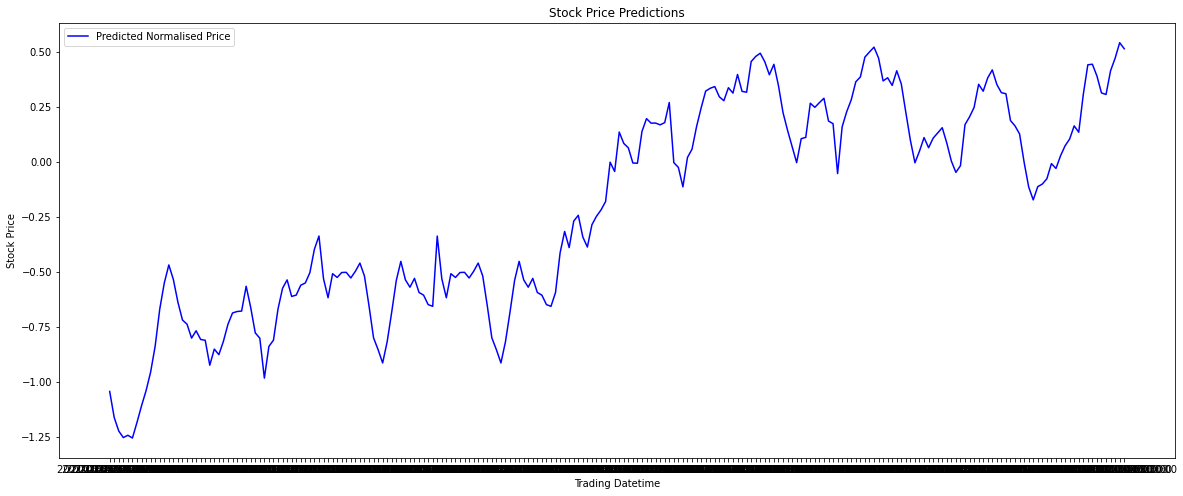

In [ ]:
# plotting the full data
plt.plot(df_normalised_pred['Pred_Norm_Close'] , color = 'blue', label = 'Predicted Normalised Price')

plt.title('Stock Price Predictions')
plt.xlabel('Trading Datetime')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

In [ ]:
df_normalised_pred.to_csv('LSTM_PFE_NormalisedPred.csv')